# Data Acquisition

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aryagijare","key":"4b2cf3c10278418c3e8d34fe23ae4706"}'}

In [ ]:
!pip install kaggle

!mkdir .kaggle

import json
token = {"username":"aryagijare","key":"4b2cf3c10278418c3e8d34fe23ae4706"} # replace with your kaggle username and generated API Key
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

# Kaggle API for dataset
!kaggle datasets download -d brain-tumor-detection

# unzip dataset after downloading
!unzip \*.zip


Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

# Import Libs

In [ ]:
#importing libs
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dropout, Activation, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras import backend as k
import tensorflow as tf

In [ ]:
# to hide the deprecation warnings (doesn't do much good though, we get a lot of warnings anyway - ignore them for now.
import warnings
warnings.filterwarnings('ignore', category= DeprecationWarning)

# Loading and Prepossessing Data

In [ ]:
# dimensions of our images
img_width, img_height = 224, 224
img_size = (224, 224)

# saving the directory/folder location for training and validation image folders to variables
train_data_dir = 'alzheimers_dataset/alzheimers_train'
test_data_dir = 'alzheimers_dataset/alzheimers_test'

# Saving the batch_size and epochs for training to variables
batch_size = 32 #usually in powers of 2 - 8, 16, 32, 64, 128
#epochs = 10
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience =2), tf.keras.callbacks.ModelCheckpoint(filepath='model.h5',
                                                                                                                   monitor='val_loss',save_best_only=True,)]


In [ ]:
# Training ImagaDataGenerator with Augmentation transf.
train_datagen = ImageDataGenerator(rescale=1./255, #normalization
                                   validation_split=0.2,
                                   vertical_flip = True,
                                   zoom_range = 0.2, # extent of adjusting the zoom in images - 20%
                                   horizontal_flip= True, # randomly flipping to get mirror images
                                   rotation_range=0.1)


# Validation ImageDataGenerator with rescaling.
# You should not apply any other transformations to the validation set because it has to reflect real world data
valid_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,)

In [ ]:
train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=10,
    image_size=[224, 224],
    batch_size=batch_size,
    color_mode="rgb"
)

validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=10,
    image_size=[224, 224],
    batch_size=batch_size,
    color_mode="rgb"
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 1279 files belonging to 4 classes.
Using 255 files for validation.


In [ ]:
# Create a flow from the directory using same seed and 'training' subset.
#train_generator = train_datagen.flow_from_directory(train_data_dir,
 #                                             subset='training',
#                                              shuffle =True,
 #                                             seed=42,
  #                                            target_size=img_size,
   #                                           batch_size=batch_size,
    #                                          #color_mode = 'grayscale',
     #                                         class_mode='categorical') # categorical for more than 2 classes



# Create a flow from the directory for validation data - seed=42
#validation_generator = valid_datagen.flow_from_directory(test_data_dir,
 #                                             subset='validation',
  #                                            seed=42,
   #                                           target_size=img_size,
    #                                          batch_size = batch_size,
                                              #color_mode = 'grayscale',
     #                                         class_mode='categorical')

Found 4098 images belonging to 4 classes.
Found 254 images belonging to 4 classes.


In [ ]:
# this batch of code checks for whether the backend (tensorflow in this case) supports the image input shape with the color
# before or after the image width and image height values. This input shape is passed as the input to the ConvNet.
if k.image_data_format() == "channels_first":
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

input_shape

(224, 224, 3)

# Build CNN

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model = tf.keras.models.Sequential([
    # First Convolution
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Second Convolution
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Third Convolution
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')  # softmax
])


model.compile(
    loss='categorical_crossentropy', #categorical_cross_entropy
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_generator, validation_data= validation_generator, epochs = 15)

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# save model and architecture to single file
model.save("full_model.h5")
print("Saved full model to disk")

Epoch 1/15
129/129 [==============================] - 55s 318ms/step - loss: 1.0824 - accuracy: 0.5022 - val_loss: 0.9622 - val_accuracy: 0.5079
Epoch 2/15
129/129 [==============================] - 41s 318ms/step - loss: 0.9317 - accuracy: 0.5586 - val_loss: 0.9464 - val_accuracy: 0.5630
Epoch 3/15
129/129 [==============================] - 41s 315ms/step - loss: 0.8958 - accuracy: 0.5832 - val_loss: 0.9501 - val_accuracy: 0.5039
Epoch 4/15
129/129 [==============================] - 41s 316ms/step - loss: 0.8663 - accuracy: 0.5925 - val_loss: 0.8751 - val_accuracy: 0.5787
Epoch 5/15
129/129 [==============================] - 41s 317ms/step - loss: 0.8492 - accuracy: 0.6030 - val_loss: 0.8828 - val_accuracy: 0.5512
Epoch 6/15
129/129 [==============================] - 41s 316ms/step - loss: 0.8313 - accuracy: 0.6079 - val_loss: 0.8600 - val_accuracy: 0.6063
Epoch 7/15
129/129 [==============================] - 41s 318ms/step - loss: 0.8105 - accuracy: 0.6218 - val_loss: 0.8524 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


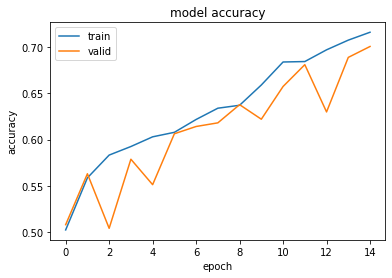

In [ ]:
print(history.history.keys()) # prints what the history has stored (stored in a dictionary format (key-value pairs))

# summarize history for accuracy on a line chart
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

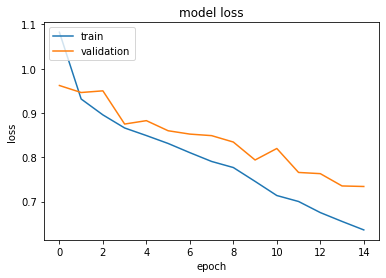

In [ ]:
# summarize history for loss on a line chart
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Eval Performance

In [ ]:
# load json file and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
from keras.models import load_model #to load the model saved as a h5 file
# load model
full_model = load_model('full_model.h5')
# summarize model.
full_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [ ]:
model.evaluate_generator(validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.7341686487197876, 0.7007874250411987]

In [ ]:
model.evaluate_generator(train_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.5632364153862, 0.7628111243247986]

In [ ]:
# load test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a flow from the directory for validation data - seed=42
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                              target_size=img_size,
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                              #color_mode = 'grayscale',
                                              shuffle=False)

Found 1279 images belonging to 4 classes.


In [ ]:
# Prints out the model loss and accuracy
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.846009373664856, 0.5910868048667908]

In [ ]:
y_true = test_generator.classes

# Get prediction probabilities from model
probabilities = model.predict(test_generator)
# Because this is a binary classification problem, you have to find predicted labels
y_pred = probabilities > 0.5


In [ ]:
len(y_true), len(y_pred)

(1279, 1279)

In [ ]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score

# Classification report will show us precision, recall and F1 Score of the model
#class_names = ['mild', 'moderate', 'non', 'very mild']
#print(classification_report(y_true, np.argmax(y_pred), target_names=class_names))
#print(classification_report(y_true, np.argmax(y_pred))
f1_score(y_true, np.argmax(y_pred, axis=1), average='weighted')



0.4118646917993556

In [ ]:
precision_score(y_true, np.argmax(y_pred, axis=1), average='weighted')


0.5557109103439174

In [ ]:
accuracy_score(y_true, np.argmax(y_pred, axis=1))
#print(accuracy)

0.4839718530101642

In [ ]:
conf_mat = confusion_matrix(y_true, np.argmax(y_pred, axis=1), labels=[2,4])
print(conf_mat)

[[464   0]
 [  0   0]]


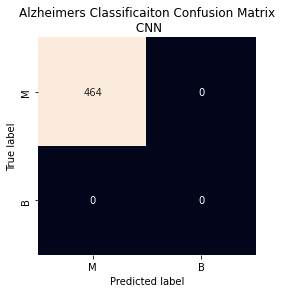

In [ ]:
# Using Seaborn to display Confusion Matrix Beautifully
# Transform to df for easier plotting

cm_df = pd.DataFrame(conf_mat,
                     index = ['M','B'],
                     columns = ['M','B'])

plt.figure(figsize=(4,4))
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Alzheimers Classificaiton Confusion Matrix\n CNN')
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.figtext(1.30, 0.01, 'Accuracy: {}%\n Sensitivity: {}\n Specificity: {} '.format(round(svc_accuracy, 2),round(sensitivity, 2),round(specificity, 2)), horizontalalignment='right')
plt.show()

# VGG19 Build

In [ ]:
# libraries for pretrained models
from keras.applications.vgg19 import VGG19

from keras.models import Sequential, Model

# loading the pretrained model
vgg_pre_trained_model = VGG19(input_shape = input_shape,
                                include_top = True,
                                weights = 'imagenet')

# freezing parameters in convolutional layers
for layer in vgg_pre_trained_model.layers:
    layer.trainable = False

vgg_pre_trained_model.summary()

574726144/574710816 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# building the model
def build_my_model(model_name):

    new_model = Sequential()
    model = vgg_pre_trained_model
    # Add the convolutional part of the nasnet model from above.
    new_model.add(model)
    # Create a custom classifier
    new_model.add(Flatten())
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.4))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(4, activation='softmax')) #softmax

    return new_model
# building nasnet model
my_vgg_model = build_my_model(vgg_pre_trained_model)

# building resnet model
# my_resnet_model = build_my_model(resnet_pre_trained_model)

my_vgg_model.summary()
my_model = my_vgg_model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1000)              143667240 
                                                                 
 flatten_3 (Flatten)         (None, 1000)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               256256    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)              

In [ ]:
# define hyperparameters
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-3) # RMSprop(learning_rate=1e-4)
loss = 'categorical_crossentropy' #categorical_crossentropy
metrics = ['accuracy']

model_path="{}_my_model.bestv.hdf5".format('class')

# save the weights of the best model during training
checkpoint = ModelCheckpoint(model_path,
                              monitor= 'val_loss',
                              verbose=1,
                              save_best_only=True,
                              mode= 'auto',
                              save_weights_only = True)

# if results have not improved after a certain number of epochs, stop training.
early = EarlyStopping(monitor= 'val_loss',
                       mode= 'auto',
                       patience=10)
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience =2), tf.keras.callbacks.ModelCheckpoint(filepath='model.h5',
                                                                                                                   monitor='val_loss',save_best_only=True,)]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
## train your model
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# my_model.load_weights(weight_path)
# Saving the history of training epochs and associated metrics to a variable (history)
history = my_model.fit(train_generator,
                          validation_data = validation_generator,
                          epochs = 25 ,
                          callbacks = callbacks_list)

Epoch 1/25
129/129 [==============================] - 50s 383ms/step - loss: 1.0815 - accuracy: 0.4905 - val_loss: 1.0279 - val_accuracy: 0.5039
Epoch 2/25
129/129 [==============================] - 51s 396ms/step - loss: 1.0514 - accuracy: 0.4863 - val_loss: 1.0279 - val_accuracy: 0.5039
Epoch 3/25
129/129 [==============================] - 50s 383ms/step - loss: 1.0487 - accuracy: 0.4993 - val_loss: 1.0378 - val_accuracy: 0.5039
Epoch 4/25
129/129 [==============================] - 49s 382ms/step - loss: 1.0431 - accuracy: 0.4985 - val_loss: 1.0261 - val_accuracy: 0.5039
Epoch 5/25
129/129 [==============================] - 49s 381ms/step - loss: 1.0457 - accuracy: 0.4968 - val_loss: 1.0224 - val_accuracy: 0.5039


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


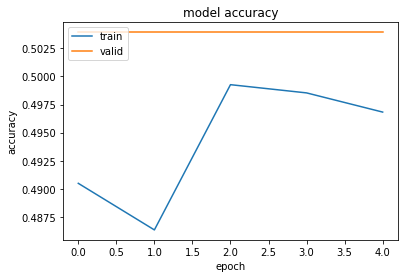

In [ ]:
print(history.history.keys()) # prints what the history has stored (stored in a dictionary format (key-value pairs))

# summarize history for accuracy on a line chart
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

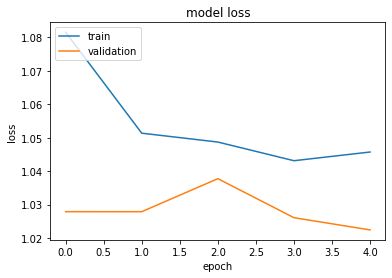

In [ ]:
# summarize history for loss on a line chart
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# VGG19 Eval Performance

In [ ]:
# load test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a flow from the directory for validation data - seed=42
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                              target_size=img_size,
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

my_model.evaluate(test_generator)

Found 1279 images belonging to 4 classes.
40/40 [==============================] - 6s 142ms/step - loss: 1.0310 - accuracy: 0.5004


[1.031027913093567, 0.5003909468650818]

In [ ]:
test_data = []
test_labels = []
batch_index = 0

while batch_index <= test_generator.batch_index:
    data = next(test_generator)
    test_data.append(data[0])
    test_labels.append(data[1])
    batch_index = batch_index + 1

test_data_array = np.asarray(test_data)
test_labels_array = np.asarray(test_labels)
y_true = test_labels_array

test_data_array.shape

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(40,)

In [ ]:
y_true = test_generator.classes

# Get prediction probabilities from model
probabilities = my_model.predict(test_generator)
# Because this is a binary classification problem, you have to find predicted labels
y_pred = probabilities > 0.5


In [ ]:
len(y_true), len(y_pred)

(1279, 1279)

In [ ]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score

# Classification report will show us precision, recall and F1 Score of the model
#class_names = ['mild', 'moderate', 'non', 'very mild']
#print(classification_report(y_true, np.argmax(y_pred), target_names=class_names))
#print(classification_report(y_true, np.argmax(y_pred))
f1_score(y_true, np.argmax(y_pred, axis=1), average='weighted')

0.36382382069325

In [ ]:
precision_score(y_true, np.argmax(y_pred, axis=1), average='weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3083878330173972

In [ ]:
accuracy_score(y_true, np.argmax(y_pred, axis=1))
#print(accuracy)

0.5027365129007036

In [ ]:
conf_mat = confusion_matrix(y_true, np.argmax(y_pred, axis=1), labels=[2,4])
print(conf_mat)

[[616   0]
 [  0   0]]


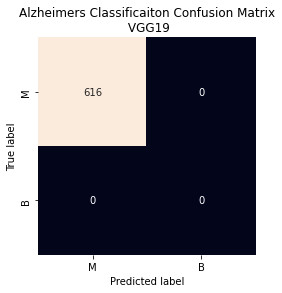

In [ ]:
# Using Seaborn to display Confusion Matrix Beautifully
# Transform to df for easier plotting

cm_df = pd.DataFrame(conf_mat,
                     index = ['M','B'],
                     columns = ['M','B'])

plt.figure(figsize=(4,4))
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Alzheimers Classificaiton Confusion Matrix\n VGG19')
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.figtext(1.30, 0.01, 'Accuracy: {}%\n Sensitivity: {}\n Specificity: {} '.format(round(svc_accuracy, 2),round(sensitivity, 2),round(specificity, 2)), horizontalalignment='right')
plt.show()

# Inception V3 Build

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential, Model

# loading the pretrained model
inception_pre_trained_model = InceptionV3(input_shape = input_shape,
                                 include_top = False,
                                 weights = 'imagenet')

# freezing parameters in convolutional layers
for layer in inception_pre_trained_model.layers:
    layer.trainable = False

inception_pre_trained_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_3[0][0]']               
 alization)           

In [ ]:
# building the model
def build_my_model(model_name):

    new_model = Sequential()
    model = inception_pre_trained_model
    # Add the convolutional part of the inception v3 model from above.
    new_model.add(model)
    # Create a custom classifier
    new_model.add(Flatten())
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.4))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(4, activation='sigmoid')) #softmax

    return new_model
# building inceptionnet model
my_inception_model = build_my_model(inception_pre_trained_model)


my_inception_model.summary()
my_model = my_inception_model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 51200)             0         
                                                                 
 dense_18 (Dense)            (None, 256)               13107456  
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 512)               131584    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 256)              

In [ ]:
# define hyperparameters
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-3) # RMSprop(learning_rate=1e-4)
loss = 'categorical_crossentropy' #categorical_crossentropy
metrics = ['accuracy']

model_path="{}_my_model.bestv.hdf5".format('class')

# save the weights of the best model during training
checkpoint = ModelCheckpoint(model_path,
                             monitor= 'val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode= 'auto',
                             save_weights_only = True)

# if results have not improved after a certain number of epochs, stop training.
early = EarlyStopping(monitor= 'val_loss',
                      mode= 'auto',
                      patience=10)

callbacks_list = [checkpoint, early]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
## train your model
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# my_model.load_weights(weight_path)
# Saving the history of training epochs and associated metrics to a variable (history)
history = my_model.fit(train_generator,
                          validation_data = validation_generator,
                          epochs = 50 ,
                          callbacks = callbacks_list)

Epoch 1/50
 59/129 [============>.................] - ETA: 23s - loss: 1.0301 - accuracy: 0.5053

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


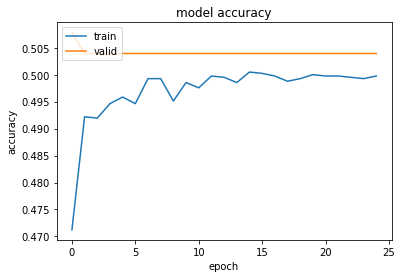

In [ ]:
print(history.history.keys()) # prints what the history has stored (stored in a dictionary format (key-value pairs))

# summarize history for accuracy on a line chart
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

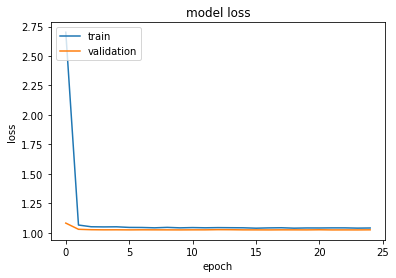

In [ ]:
# summarize history for loss on a line chart
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Inception V3 Eval Performance

In [ ]:
# load test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a flow from the directory for validation data - seed=42
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                              target_size=img_size,
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

my_model.evaluate(test_generator)

Found 1279 images belonging to 4 classes.
40/40 [==============================] - 4s 104ms/step - loss: 1.0337 - accuracy: 0.5004


[1.0336904525756836, 0.5003909468650818]

In [ ]:
test_data = []
test_labels = []
batch_index = 0

while batch_index <= test_generator.batch_index:
    data = next(test_generator)
    test_data.append(data[0])
    test_labels.append(data[1])
    batch_index = batch_index + 1

test_data_array = np.asarray(test_data)
test_labels_array = np.asarray(test_labels)
y_true = test_labels_array

test_data_array.shape

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(40,)

In [ ]:
y_true = test_generator.classes

# Get prediction probabilities from model
probabilities = my_model.predict(test_generator)
# Because this is a binary classification problem, you have to find predicted labels
y_pred = probabilities > 0.5


In [ ]:
len(y_true), len(y_pred)

(1279, 1279)

In [ ]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score

# Classification report will show us precision, recall and F1 Score of the model
#class_names = ['mild', 'moderate', 'non', 'very mild']
#print(classification_report(y_true, np.argmax(y_pred), target_names=class_names))
#print(classification_report(y_true, np.argmax(y_pred))
f1_score(y_true, np.argmax(y_pred, axis=1), average='weighted')

0.333767791000737

In [ ]:
precision_score(y_true, np.argmax(y_pred, axis=1), average='weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25039108324097514

In [ ]:
accuracy_score(y_true, np.argmax(y_pred, axis=1))
#print(accuracy)

0.5003909304143862

In [ ]:
conf_mat = confusion_matrix(y_true, np.argmax(y_pred, axis=1), labels=[2,4])
print(conf_mat)

[[640   0]
 [  0   0]]


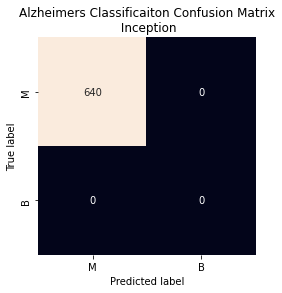

In [ ]:
# Using Seaborn to display Confusion Matrix Beautifully
# Transform to df for easier plotting

cm_df = pd.DataFrame(conf_mat,
                     index = ['M','B'],
                     columns = ['M','B'])

plt.figure(figsize=(4,4))
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Alzheimers Classificaiton Confusion Matrix\n Inception')
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.figtext(1.30, 0.01, 'Accuracy: {}%\n Sensitivity: {}\n Specificity: {} '.format(round(svc_accuracy, 2),round(sensitivity, 2),round(specificity, 2)), horizontalalignment='right')
plt.show()

# ResNet50 Build

In [ ]:
from keras.applications.resnet import ResNet50
from keras.models import Sequential, Model

# loading the pretrained model
resnet_pre_trained_model = ResNet50(input_shape = input_shape,
                                 include_top = False,
                                 weights = 'imagenet')

# freezing parameters in convolutional layers
for layer in resnet_pre_trained_model.layers:
    layer.trainable = False

resnet_pre_trained_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
# building the model
def build_my_model(model_name):

    new_model = Sequential()
    model = resnet_pre_trained_model
    # Add the convolutional part of the resnet model from above.
    new_model.add(model)
    # Create a custom classifier
    new_model.add(Flatten())
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.4))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(4, activation='sigmoid')) #softmax

    return new_model
# building resnet model
my_resnet_model = build_my_model(resnet_pre_trained_model)


my_resnet_model.summary()
my_model = my_resnet_model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [ ]:
# define hyperparameters
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-3) # RMSprop(learning_rate=1e-4)
loss = 'categorical_crossentropy' #categorical_crossentropy
metrics = ['accuracy']

model_path="{}_my_model.bestv.hdf5".format('class')

# save the weights of the best model during training
checkpoint = ModelCheckpoint(model_path,
                             monitor= 'val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode= 'auto',
                             save_weights_only = True)

# if results have not improved after a certain number of epochs, stop training.
early = EarlyStopping(monitor= 'val_loss',
                      mode= 'auto',
                      patience=10)

callbacks_list = [checkpoint, early]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
## train your model
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# my_model.load_weights(weight_path)
# Saving the history of training epochs and associated metrics to a variable (history)
history = my_model.fit(train_generator,
                          validation_data = validation_generator,
                          epochs = 25 ,
                          callbacks = callbacks_list)

Epoch 1/25


ValueError: ignored

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


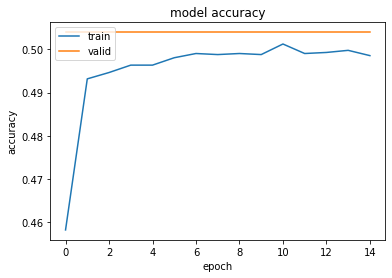

In [ ]:
print(history.history.keys()) # prints what the history has stored (stored in a dictionary format (key-value pairs))

# summarize history for accuracy on a line chart
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

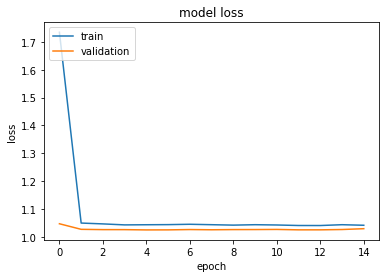

In [ ]:
# summarize history for loss on a line chart
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# ResNet50 Eval Performance

In [ ]:
# load test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a flow from the directory for validation data - seed=42
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                              target_size=img_size,
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

my_model.evaluate(test_generator)

Found 1279 images belonging to 4 classes.
40/40 [==============================] - 11s 268ms/step - loss: 1.0367 - accuracy: 0.5004


[1.0367299318313599, 0.5003909468650818]

In [ ]:
test_data = []
test_labels = []
batch_index = 0

while batch_index <= test_generator.batch_index:
    data = next(test_generator)
    test_data.append(data[0])
    test_labels.append(data[1])
    batch_index = batch_index + 1

test_data_array = np.asarray(test_data)
test_labels_array = np.asarray(test_labels)
y_true = test_labels_array

test_data_array.shape

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(40,)

In [ ]:
y_true = test_generator.classes

# Get prediction probabilities from model
probabilities = my_model.predict(test_generator)
# Because this is a binary classification problem, you have to find predicted labels
y_pred = probabilities > 0.5


In [ ]:
len(y_true), len(y_pred)

(1279, 1279)

In [ ]:
class_names = train_datagen.class_names

test_images = []

for label in class_names:
    dir_name = test_data_dir + label
    test_images.append(len([name for name in os.listdir(dir_name)]))
test_images

AttributeError: ignored

In [ ]:
targets=[]
for i in range(0, len(test_images)):
    targets+=[i]*test_images[i]
targets=np.asarray(targets)
test_images, class_names, targets


from sklearn.metrics import classification_report
print(classification_report(np.asarray(targets), np.argmax(predictions, axis=1), target_names=class_names))

NameError: ignored

In [ ]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score

# Classification report will show us precision, recall and F1 Score of the model
#class_names = ['mild', 'moderate', 'non', 'very mild']
#print(classification_report(y_true, np.argmax(y_pred), target_names=class_names))
#print(classification_report(y_true, np.argmax(y_pred))
f1_score(y_true, np.argmax(y_pred, axis=1), average='micro')

0.5003909304143862

In [ ]:
precision_score(y_true, np.argmax(y_pred, axis=1), average='micro')

0.5003909304143862

In [ ]:
accuracy_score(y_true, np.argmax(y_pred, axis=1))
#print(accuracy)

0.5003909304143862

In [ ]:
conf_mat = confusion_matrix(y_true, np.argmax(y_pred, axis=1), labels=[2,4])
print(conf_mat)

[[640   0]
 [  0   0]]


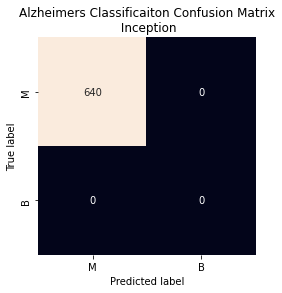

In [ ]:
# Using Seaborn to display Confusion Matrix Beautifully
# Transform to df for easier plotting

cm_df = pd.DataFrame(conf_mat,
                     index = ['M','B'],
                     columns = ['M','B'])

plt.figure(figsize=(4,4))
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Alzheimers Classificaiton Confusion Matrix\n Inception')
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.figtext(1.30, 0.01, 'Accuracy: {}%\n Sensitivity: {}\n Specificity: {} '.format(round(svc_accuracy, 2),round(sensitivity, 2),round(specificity, 2)), horizontalalignment='right')
plt.show()